#Chetna Mundra - 1BM21AI036 - CYA AAT

# Importing libraries

In [8]:
from imblearn.over_sampling import RandomOverSampler, ADASYN
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, ParameterGrid, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
#from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn import metrics




import warnings
warnings.filterwarnings("ignore")

# Reading Data

In [9]:
df = pd.read_csv("creditcard.csv")

In [10]:
classes=df['Class'].value_counts()
normal_share=classes[0]/df['Class'].count()*100
fraud_share=classes[1]/df['Class'].count()*100

In [11]:
classes

,count
Class,
0,284315
1,492


In [12]:
df['TimeMin'] = df['Time'] / 60
df['TimeHour'] = df['Time'] / 60**2

In [13]:
df.drop(['Time', 'TimeMin', 'TimeHour'], axis=1, inplace=True)

# Train test split

In [14]:
# Train test split
y = df.pop("Class")
X = df

# Using stratify=y for splitting data into stratified fashion
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, stratify=y, random_state=42)

# Results

In [20]:
# creating a results dataframe for later to evaluate the models
results = pd.DataFrame(columns = ['model_name', 'threshold', 'recall', 'roc_auc_score'])

# Model Evaluation Function

In [21]:
def model_evaluation(y_pred_proba_test):
#     Report for different thresholds
    thresholds = [i * 0.1 for i in range(0, 10)]
    print("----------------------------Results----------------------------")
#     best ROC score initialisation
    best_roc_score = 0

#     Iterating through every threshold from 0.1 to 0.9
    for threshold in thresholds:
        y_pred = np.where(y_pred_proba_test[:, 1] > threshold, 1, 0)
#   Calculating different metrics
        accuracy = str(round(metrics.accuracy_score(y_test, y_pred), 3))
        precision = str(round(metrics.precision_score(y_test, y_pred), 3))
        recall = str(round(metrics.recall_score(y_test, y_pred), 3))
        roc_auc = str(round(metrics.roc_auc_score(y_test, y_pred), 3))
#   Setting the best roc score, threshold, recall scores.
        if float(roc_auc) > best_roc_score:
            best_roc_score = float(roc_auc)
            best_threshold = threshold
            best_recall_score = recall
#   printing the results for every threshold
        print("----------for Test with threshold", round(threshold, 2), "----------")
        print("accuracy\tprecision\trecall\t\troc_auc")
        print("\t\t".join([accuracy, precision, recall, roc_auc]))
        print("\n")
#   Confusion Matrix
        print("\t\tCONFUSION MATRIX")
        confusion_matrix = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred),
                                        columns=['Predicted Negative', 'Predicted Positive'],
                                        index=['Actual Negative', 'Actual Positive'])
        print(confusion_matrix)
        print("\n")
    print("BEST ROC AUC SCORE is ", best_roc_score, "at the threshold", best_threshold)
    return best_roc_score, best_threshold, best_recall_score

# Draw ROC

In [22]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

#XG BOOST

Fitting 3 folds for each of 4 candidates, totalling 12 fits
BEST GRID SCORE nan
BEST GRID PARAMS
{'xgbclassifier__max_depth': 3, 'xgbclassifier__n_estimators': 50}
----------------------------Results----------------------------
----------for Test with threshold 0.0 ----------
accuracy	precision	recall		roc_auc
0.002		0.002		1.0		0.5


		CONFUSION MATRIX
                 Predicted Negative  Predicted Positive
Actual Negative                   0               71079
Actual Positive                   0                 123


----------for Test with threshold 0.1 ----------
accuracy	precision	recall		roc_auc
0.999		0.75		0.829		0.914


		CONFUSION MATRIX
                 Predicted Negative  Predicted Positive
Actual Negative               71045                  34
Actual Positive                  21                 102


----------for Test with threshold 0.2 ----------
accuracy	precision	recall		roc_auc
0.999		0.852		0.797		0.898


		CONFUSION MATRIX
                 Predicted Negative  Pred

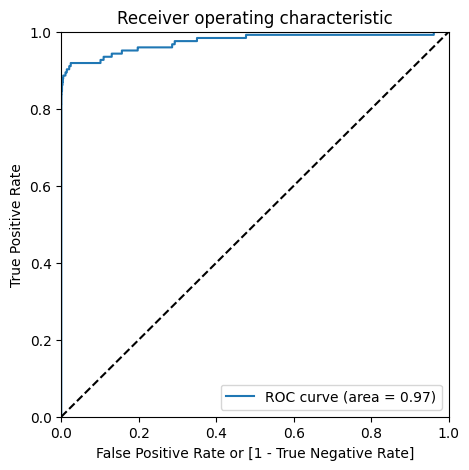

In [24]:
# Import necessary libraries
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
import pandas as pd

# Initialize the XGBoost model
def initialize_xgboost():
    return xgb.XGBClassifier(eval_metric='logloss', n_estimators=100, max_depth=3)

# Train the model using GridSearchCV with pipeline
def train_xgboost(X_train, y_train, cv):
    xgb_model = initialize_xgboost()
    pipeline = make_pipeline(xgb_model)
    param_grid = {
        'xgbclassifier__n_estimators': [50, 100],
        'xgbclassifier__max_depth': [3, 5]
    }
    grid = GridSearchCV(pipeline, param_grid=param_grid, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=1000)
    grid.fit(X_train, y_train)
    print("BEST GRID SCORE", grid.best_score_)
    print("BEST GRID PARAMS")
    print(grid.best_params_)
    return grid.best_estimator_.named_steps['xgbclassifier']

# Evaluate the model
def evaluate_xgboost(model, X_test, y_test):
    # Get the predicted probabilities for both classes
    y_pred_proba_test = model.predict_proba(X_test)
    # Pass the full probability array to model_evaluation
    best_roc_score, best_threshold, best_recall_score = model_evaluation(y_pred_proba_test)
    return best_roc_score, best_threshold, best_recall_score

# Example usage
cv = KFold(3)
best_xgb_model = train_xgboost(X_train, y_train, cv)
best_roc_score, best_threshold, best_recall_score = evaluate_xgboost(best_xgb_model, X_test, y_test)

# Update results dataframe
data = pd.DataFrame([['XGBOOST', best_threshold, best_recall_score, best_roc_score]], columns=results.columns)
results = pd.concat([results, data], ignore_index=False)

# Optional: Plot ROC curve
draw_roc(y_test, best_xgb_model.predict_proba(X_test)[:, 1])

#Random Forest

----------------------------Results----------------------------
----------for Test with threshold 0.0 ----------
accuracy	precision	recall		roc_auc
0.002		0.002		1.0		0.5


		CONFUSION MATRIX
                 Predicted Negative  Predicted Positive
Actual Negative                   1               71078
Actual Positive                   0                 123


----------for Test with threshold 0.1 ----------
accuracy	precision	recall		roc_auc
0.999		0.707		0.846		0.922


		CONFUSION MATRIX
                 Predicted Negative  Predicted Positive
Actual Negative               71036                  43
Actual Positive                  19                 104


----------for Test with threshold 0.2 ----------
accuracy	precision	recall		roc_auc
0.999		0.811		0.837		0.919


		CONFUSION MATRIX
                 Predicted Negative  Predicted Positive
Actual Negative               71055                  24
Actual Positive                  20                 103


----------for Test with threshold 

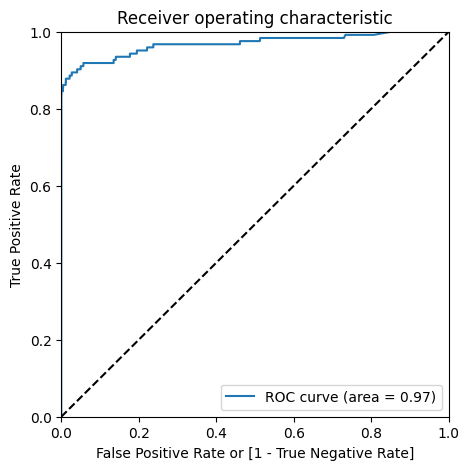

In [28]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd

# Train a simple Random Forest model
def train_random_forest(X_train, y_train):
    rf_model = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)
    rf_model.fit(X_train, y_train)
    return rf_model

# Example usage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)
best_rf_model = train_random_forest(X_train, y_train)

# Evaluate the model using the existing function
y_pred_proba_test = best_rf_model.predict_proba(X_test)
best_roc_score, best_threshold, best_recall_score = model_evaluation(y_pred_proba_test)

# Update results dataframe
data = pd.DataFrame([['RANDOM FOREST', best_threshold, best_recall_score, best_roc_score]], columns=results.columns)
results = pd.concat([results, data], ignore_index=False)

# Optional: Plot ROC curve
draw_roc(y_test, y_pred_proba_test[:, 1])


#Using SMOTE analsyis

----------------------------Results----------------------------
----------for Test with threshold 0.0 ----------
accuracy	precision	recall		roc_auc
0.002		0.002		1.0		0.5


		CONFUSION MATRIX
                 Predicted Negative  Predicted Positive
Actual Negative                   0               71079
Actual Positive                   0                 123


----------for Test with threshold 0.1 ----------
accuracy	precision	recall		roc_auc
0.879		0.013		0.943		0.911


		CONFUSION MATRIX
                 Predicted Negative  Predicted Positive
Actual Negative               62471                8608
Actual Positive                   7                 116


----------for Test with threshold 0.2 ----------
accuracy	precision	recall		roc_auc
0.936		0.024		0.911		0.923


		CONFUSION MATRIX
                 Predicted Negative  Predicted Positive
Actual Negative               66546                4533
Actual Positive                  11                 112


----------for Test with threshold 

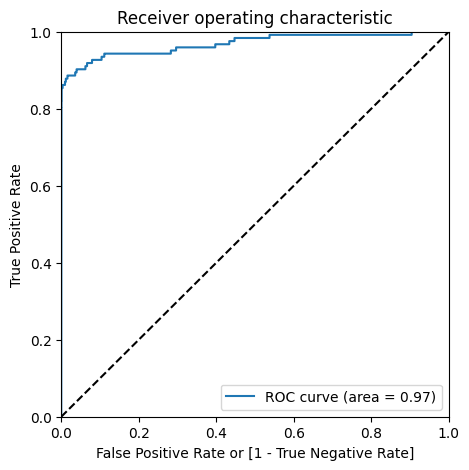

In [29]:
# Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import pandas as pd

# Apply SMOTE to balance the dataset
def apply_smote(X_train, y_train):
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    return X_resampled, y_resampled

# Train a simple Logistic Regression model
def train_logistic_regression(X_train, y_train):
    lr_model = LogisticRegression(max_iter=1000, random_state=42)
    lr_model.fit(X_train, y_train)
    return lr_model

# Example usage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)
X_resampled, y_resampled = apply_smote(X_train, y_train)

best_lr_model = train_logistic_regression(X_resampled, y_resampled)

# Evaluate the model using the existing function
y_pred_proba_test = best_lr_model.predict_proba(X_test)
best_roc_score, best_threshold, best_recall_score = model_evaluation(y_pred_proba_test)

# Update results dataframe
data = pd.DataFrame([['LOGISTIC REGRESSION (SMOTE)', best_threshold, best_recall_score, best_roc_score]], columns=results.columns)
results = pd.concat([results, data], ignore_index=False)

# Optional: Plot ROC curve
draw_roc(y_test, y_pred_proba_test[:, 1])


In [30]:
results.sort_values("recall", ascending=False, inplace=True)
# results.to_csv("results.csv", index = False) #for saving the data frame to csv file
results

,model_name,threshold,recall,roc_auc_score
0,LOGISTIC REGRESSION (SMOTE),0.5,0.886,0.934000
0,RANDOM FOREST,0.1,0.846,0.922000
0,XGBOOST,0.1,0.829,0.914000
0,RANDOM FOREST,NaN,None,0.968519
